In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
%cd ../..

In [418]:
from src.conrl import ConRL
from src.qlearning import QLearningAgent
from src.utils import *
from src.plotting import *

import itertools
import time
import numpy as np
import pandas as pd
import gym
import time
import sys
import copy
from collections import namedtuple

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.collections as mc

%matplotlib inline
plt.style.use('seaborn')
np.set_printoptions(precision=3, linewidth=80)

## Q-Learning

In [275]:
state_size = (10, 10)
env = DiscretizationWrapper(gym.make('MountainCar-v0'), state_size)

num_episodes = 500
max_step = 1000
env.env._max_episode_steps = max_step

q_params = {
    "gamma": 0.9,
    "alpha": 0.1,
    "alpha_decay_rate": 0,
    "min_alpha": 0.1,
    "epsilon": 1.0,
    "epsilon_decay_rate": 0,
    "min_epsilon": 0.1
}

q_params["epsilon_decay_rate"] = (q_params["epsilon"] - q_params["min_epsilon"])/(num_episodes//2)
q_params["alpha_decay_rate"] = (q_params["alpha"] - q_params["min_alpha"])/(num_episodes//2)



In [350]:
stats_q =   {
            "step":  np.zeros(num_episodes),
            "cumulative_reward":  np.zeros(num_episodes),
            "q_tables": np.zeros(shape = (num_episodes, ) + state_size + (env.action_space.n, ))
            }

q_agent = QLearningAgent(action_size=env.action_space.n, state_size=state_size, **q_params)

q_agent.train(env, num_episodes, stats_q)

Episode 0/500, Reward -1000.0, Total steps 1000.0, Epsilon: 1.00, Alpha: 0.10, Time 0.119
Episode 100/500, Reward -1000.0, Total steps 1000.0, Epsilon: 0.64, Alpha: 0.10, Time 0.086
Episode 200/500, Reward -233.0, Total steps 233.0, Epsilon: 0.28, Alpha: 0.10, Time 0.017
Episode 300/500, Reward -268.0, Total steps 268.0, Epsilon: 0.10, Alpha: 0.10, Time 0.021
Episode 400/500, Reward -290.0, Total steps 290.0, Epsilon: 0.10, Alpha: 0.10, Time 0.037


## Con-RL

In [297]:
state_size = (10, 10)
env = DiscretizationWrapper(gym.make('MountainCar-v0'), state_size)

num_episodes = 500
max_step = 1000
env.env._max_episode_steps = max_step
env.spec.max_episode_steps = max_step

q_params = {
    "gamma": 0.9,
    "alpha": 0.1,
    "alpha_decay_rate": 0,
    "min_alpha": 0.1,
    "epsilon": 1.0,
    "epsilon_decay_rate": 0,
    "min_epsilon": 0.1
}

q_params["epsilon_decay_rate"] = (q_params["epsilon"] - q_params["min_epsilon"])/(num_episodes//2)
q_params["alpha_decay_rate"] = (q_params["alpha"] - q_params["min_alpha"])/(num_episodes//2)

mlgng_params = {
    "ndim": 2, 
    "e_w":0.5, 
    "e_n":0.1, 
    "l":10, 
    "a":0.5, 
    "b":0.05,
    "k":1000.0, 
    "max_nodes": 10, 
    "max_age": 10
}

In [344]:
stats_cr= {
        "step":  np.zeros(num_episodes),
        "cumulative_reward":  np.zeros(num_episodes),
        "selector":    np.zeros(num_episodes),
        "mlgng_nodes":      [],
        "best_actions":     [],
}

conrl = ConRL(action_size=env.action_space.n, state_size=state_size, update_threshold=10)
conrl.init_support(**q_params)
conrl.init_mlgng(**mlgng_params)

conrl.train(env, num_episodes, stats_cr)


Episode 0/500, Reward -1000.0, Total steps 1000.0, Epsilon: 1.00, Alpha: 0.10, Time 0.179
	 MLGNG nodes per action layer: 0 0 0
Episode 100/500, Reward -178.0, Total steps 178.0, Epsilon: 0.64, Alpha: 0.10, Time 0.167
	 MLGNG nodes per action layer: 3 2 3
Episode 200/500, Reward -284.0, Total steps 284.0, Epsilon: 0.28, Alpha: 0.10, Time 0.256
	 MLGNG nodes per action layer: 10 10 10
Episode 300/500, Reward -171.0, Total steps 171.0, Epsilon: 0.10, Alpha: 0.10, Time 0.250
	 MLGNG nodes per action layer: 10 10 10
Episode 400/500, Reward -308.0, Total steps 308.0, Epsilon: 0.10, Alpha: 0.10, Time 0.532
	 MLGNG nodes per action layer: 10 9 10


## Statistics

In [301]:
act_dict = {
    0: "Push left",
    1: "No push",
    2: "Push right"
}

act_symbol = {
    0:  "o",
    1: "^",
    2: "s",
}
act_color = cm.Dark2(np.linspace(0.1, 1, 3, endpoint=False))


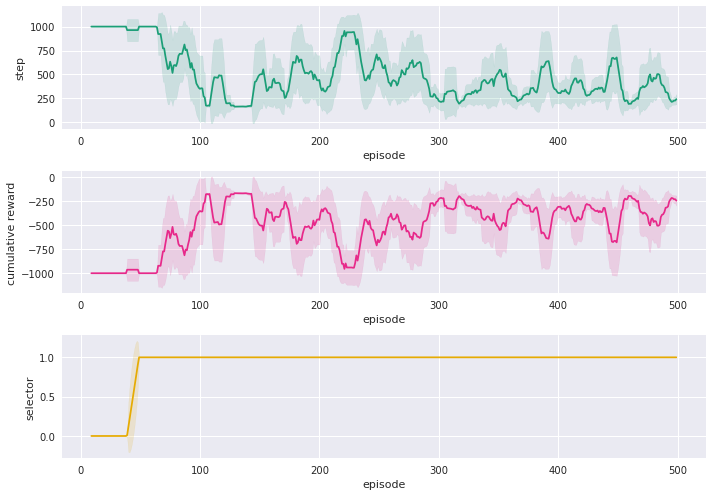

In [522]:
to_plot = ["step", "cumulative_reward", "selector"]

stats_to_plot = {key: value for key, value in stats_cr.items() if key in to_plot}
plot_stats(stats_to_plot, colors=act_color, figsize=(10, 7))

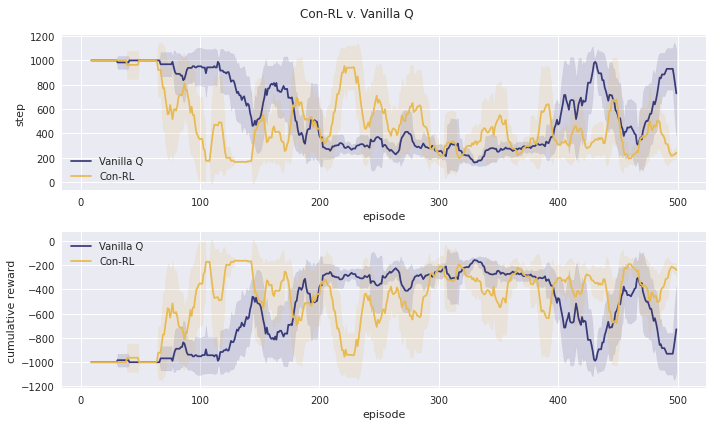

In [400]:
to_plot = ["step", "cumulative_reward"]
plot_stats_comparison({
    "Vanilla Q": {key: value for key, value in stats_q.items() if key in to_plot}, 
    "Con-RL": {key: value for key, value in stats_cr.items() if key in to_plot}
},
title="Con-RL v. Vanilla Q")

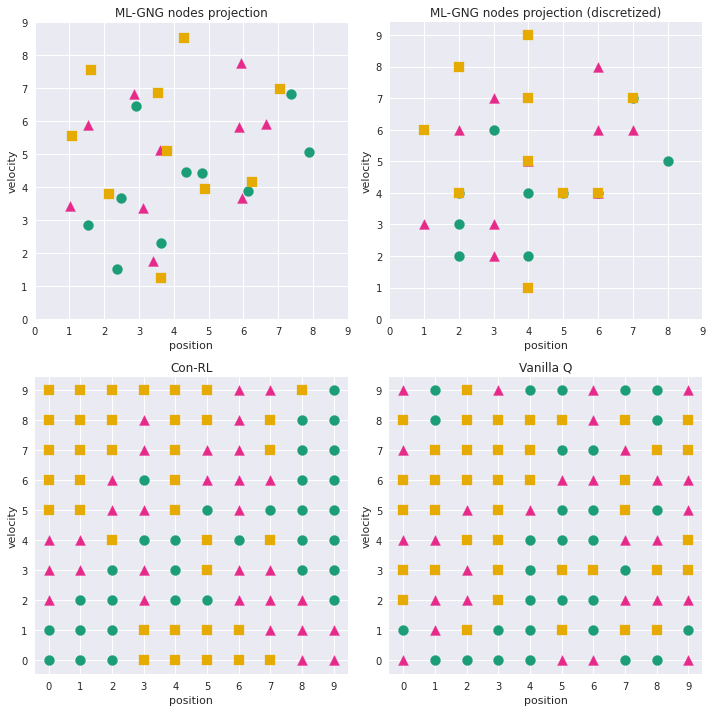

In [534]:
nodes = conrl.mlgng.get_nodes()

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
ax = ax.flatten()

project_nodes(nodes=nodes, 
            state_size=state_size, 
            action_names=act_dict, 
            symbols=act_symbol, 
            colors=act_color,
            axis_names=["position", "velocity"],
            title="ML-GNG nodes projection",
            round=False,
            def_plot=(fig, ax[0]))

project_nodes(nodes=nodes, 
            state_size=state_size, 
            action_names=act_dict, 
            symbols=act_symbol, 
            colors=act_color,
            axis_names=["position", "velocity"],
            title="ML-GNG nodes projection (discretized)",
            round=True,
            def_plot=(fig, ax[1]),)

project_nodes(nodes=conrl.get_best_actions(), 
            state_size=state_size, 
            action_names=act_dict, 
            symbols=act_symbol, 
            colors=act_color,
            axis_names=["position", "velocity"],
            title="Con-RL",
            def_plot=(fig, ax[2]))

project_nodes(nodes=q_agent.get_best_actions(), 
            state_size=state_size, 
            action_names=act_dict, 
            symbols=act_symbol, 
            colors=act_color,
            axis_names=["position", "velocity"],
            title="Vanilla Q",
            def_plot=(fig, ax[3]))

fig.tight_layout()